In [1]:
import numpy as np
from random_mdp import MDPEnv, MDPEnvDiscreteRew, MDPEnvBernoulliRew
from agent import QlearningAgent
from greedy_policy import EpsilonGreedyPolicy, TableBasedPolicy, MixedPolicy
from utils import get_data, collect_exp, train_predictor, train_behaviour_policy, compute_weight, compute_weights_gradient, train_weight_function
from networks import MLP, WeightsMLP
from dynamics_model import DynamicsModel, DiscreteRewardDynamicsModel
import torch
from collections import defaultdict
import pickle
import random
from weights import WeightsEstimator
from conformal_set import ConformalSet
def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
set_seed(1)

REWARD_TYPE = "discrete_multiple"
GRADIENT_BASED = True
EPSILON = 0.3
QUANTILE = 0.1
LR = 1e-4
MOMENTUM = 0.9
EPOCHS = 300
NUM_ACTIONS = 5                                                                     # MDP action space size
NUM_STATES = 30                                                                     # MDP states space size
NUM_REWARDS = 10                                                                    # MDP reward space size (for discrete MDP)
DISCOUNT_FACTOR = 0.99                                                              # behaviour agent discount factor
ALPHA = 0.6                                                                         # behaviour agent alpha
NUM_STEPS = 10000                                                                   # behaviour agent learning steps
N_TRAJECTORIES = 20000                                                              # number of trajectories collected as dataset
HORIZON = 30                                                                        # trajectory horizon

P = np.random.dirichlet(np.ones(NUM_STATES), size=(NUM_STATES, NUM_ACTIONS))        # MDP transition probability functions

if REWARD_TYPE == "bernoulli":
    R = np.random.rand(NUM_STATES, NUM_ACTIONS)                                     # MDP reward function Bernoulli
    env = MDPEnvBernoulliRew(NUM_STATES, NUM_ACTIONS, P, R)
    model = DiscreteRewardDynamicsModel(NUM_STATES, NUM_ACTIONS, NUM_REWARDS)
elif REWARD_TYPE == "discrete_multiple":                                 
    R = np.random.dirichlet(np.ones(NUM_REWARDS), size=(NUM_STATES, NUM_ACTIONS))   # MDP reward function multiple discrete r values
    env = MDPEnvDiscreteRew(NUM_STATES, NUM_ACTIONS, NUM_REWARDS, P, R)
    model = DiscreteRewardDynamicsModel(NUM_STATES, NUM_ACTIONS, NUM_REWARDS)
elif REWARD_TYPE == "continuous":
    # TODO: implement continuous rewards model, the "true" MDP we already have
    R = np.random.rand(NUM_STATES, NUM_ACTIONS, NUM_STATES)
    env = MDPEnv(NUM_STATES, NUM_ACTIONS, P, R)

pi_star_probs = np.random.dirichlet(np.ones(NUM_ACTIONS), size=(NUM_STATES))
pi_star_pre = TableBasedPolicy(pi_star_probs)


#Train behaviour policy using Q-learning
agent = QlearningAgent(env.ns, NUM_ACTIONS, DISCOUNT_FACTOR, ALPHA)

q_table = train_behaviour_policy(env, agent, NUM_STEPS)
behaviour_policy = EpsilonGreedyPolicy(q_table, EPSILON, NUM_ACTIONS)

#Collect experience data using behaviour policy and train model
#TODO: improve storage system
model, dataset = get_data(env, N_TRAJECTORIES, behaviour_policy, model, REWARD_TYPE, HORIZON)

#Split dataset into training (90%) and calibration data (10%)
calibration_trajectories = N_TRAJECTORIES // 10
data_tr = dataset[:N_TRAJECTORIES - calibration_trajectories]
data_cal = dataset[N_TRAJECTORIES - calibration_trajectories:N_TRAJECTORIES]
test_state = np.random.randint(NUM_STATES)

#Train quantile predictors using training dataset
print('> Training/loading quantile networks')
upper_quantile_net = MLP(1, 32, 1, False)
lower_quantile_net = MLP(1, 32, 1, False)

if not lower_quantile_net.load('./data/networks/lower_quantile_net.pth'):
    y_avg, y_std = train_predictor(lower_quantile_net, data_tr, epochs=EPOCHS, quantile=QUANTILE/2, lr=LR, momentum=MOMENTUM)
    lower_quantile_net.set_normalization(y_avg, y_std)
    lower_quantile_net.save('./data/networks/lower_quantile_net.pth')

if not upper_quantile_net.load('./data/networks/upper_quantile_net.pth'):
    y_avg, y_std = train_predictor(upper_quantile_net, data_tr, epochs=EPOCHS, quantile=1-(QUANTILE/2), lr=LR, momentum=MOMENTUM)
    upper_quantile_net.set_normalization(y_avg, y_std)
    upper_quantile_net.save('./data/networks/upper_quantile_net.pth')

> Loading/collecting data
> Training/loading quantile networks


In [20]:
from tqdm.notebook import tqdm

epsilons = np.linspace(0.05, 0.9, 10)
N_SIMS = 10

epsilon_avg_lengths = np.zeros((N_SIMS, len(epsilons)))
epsilon_std_lengths = np.zeros((N_SIMS, len(epsilons)))
coverages = np.zeros((N_SIMS, len(epsilons)))

for n in range(N_SIMS):
    print(f'Sim: {n}')
    for id_epsilon, epsilon_value in enumerate(epsilons):
        print(f'Epsilon = {epsilon_value}')
        pi_star = MixedPolicy(pi_star_pre, behaviour_policy, epsilon_value)
        test_points = collect_exp(env, 100, HORIZON, pi_star, None, test_state)

        print(f'> Estimate weights for calibration data')
        weights_estimator = WeightsEstimator(behaviour_policy, pi_star, lower_quantile_net, upper_quantile_net)
        if GRADIENT_BASED:
            scores, weights, weight_network = weights_estimator.gradient_method(data_tr, data_cal, LR, EPOCHS, lambda:WeightsMLP(2, 32, 1, upper_quantile_net.mean, upper_quantile_net.std))
        else:
            scores, weight = weights_estimator.model_based(data_tr, data_cal, HORIZON, model)

        # Generate y values for test point
        print(f'> Computing conformal set')
        conformal_set = ConformalSet(lower_quantile_net, upper_quantile_net, behaviour_policy, pi_star, model, HORIZON)
        y_set, intervals = conformal_set.build_set(test_points, weights, scores, weight_network, GRADIENT_BASED)

        included = 0
        lengths = []
        for interval in intervals:
            if interval[-1] >= interval[2] and interval[-1] <= interval[3]:
                included += 1
            lengths.append(interval[3]-interval[2])

        included = included/len(intervals)
        mean_length = np.mean(lengths)
        epsilon_avg_lengths[n, id_epsilon] = mean_length
        epsilon_std_lengths[n, id_epsilon] = np.std(lengths)
        coverages[n, id_epsilon] = included * 100
        print("Coverage: {:.2f}% | Average interval length: {}".format(included*100, mean_length))

  0%|          | 0/10 [00:00<?, ?it/s]

> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 97 - Training weights network - Loss: 3.4745285120152403e-06 - Loss val: 9.341193617729004e-06:  33%|███▎      | 98/300 [00:10<00:20,  9.66it/s]


KeyboardInterrupt: 

In [6]:
data_new = epsilon_lengths

Text(0, 0.5, 'Interval length')

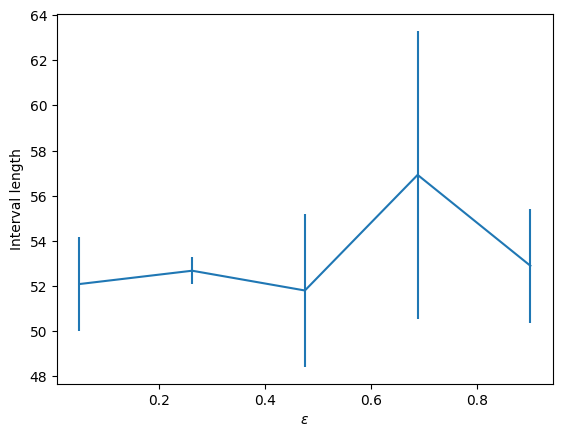

In [16]:
import matplotlib.pyplot as plt
plt.errorbar(epsilons, data_new.mean(0), 2.2*data_new.std(0) / np.sqrt(5))
plt.xlabel('$\epsilon$')
plt.ylabel('Interval length')